# ID5059 Group Project
## Weather Prediction

### 1. Data Preprocessing

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patheffects as PathEffects
import seaborn as sns

from scipy.interpolate import griddata

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [ ]:
from tensorflow import keras

In [ ]:
randomState = 1

#### 1.1 Load the data

In [ ]:
# function reads in data from file
def loadData(fileName, filePath = "./", deliniator = ","):
    path = Path() / filePath / fileName; print(path)
    if not path.is_file():
        raise Exception("File not found")

    return pd.read_csv(path, sep = deliniator)

In [ ]:
# read in training data
# no need to load in test data until it needs to be used
# takes ~20s to run

filePath = "./"

dataTrain = loadData("train.csv", filePath)

train.csv


In [ ]:
dataTrain.shape

(13288920, 13)

In [ ]:
dataTrain.head(2)

id           valid_time  latitude  longitude        tp       u10       v10   
0   1  2018-01-01 00:00:00      59.0      -8.00  0.000004  1.405868 -1.367767  \
1   2  2018-01-01 00:00:00      59.0      -7.75  0.000017  2.151962 -1.555267   

         sp      u100      v100       tcc  ptype        t2m  
0  98134.81  1.516388 -1.468002  0.968842    1.0  279.75903  
1  98086.81  2.239044 -1.634994  0.978790    1.0  279.61255

#### 1.2 Drop Unique Identifier
We see that the data has a unique identifier, "id". This interferes with the model making predictions, and is, therefore, dropped.

In [ ]:
dataTrain.drop(["id"], axis = 1, inplace = True)
print(dataTrain.shape)
dataTrain.head(2)

(13288920, 12)


valid_time  latitude  longitude        tp       u10       v10   
0  2018-01-01 00:00:00      59.0      -8.00  0.000004  1.405868 -1.367767  \
1  2018-01-01 00:00:00      59.0      -7.75  0.000017  2.151962 -1.555267   

         sp      u100      v100       tcc  ptype        t2m  
0  98134.81  1.516388 -1.468002  0.968842    1.0  279.75903  
1  98086.81  2.239044 -1.634994  0.978790    1.0  279.61255

#### 1.3 Check for Null/Empty Values

In [ ]:
# Check data types
print("Training data types:")
dataTrain.dtypes

# Summary statistics
print("\nSummary statistics for numerical columns:")
dataTrain.describe()

# Check for missing values
print("\nMissing values in training data:")
print(dataTrain.isnull().sum())

Training data types:

Summary statistics for numerical columns:

Missing values in training data:
valid_time    0
latitude      0
longitude     0
tp            0
u10           0
v10           0
sp            0
u100          0
v100          0
tcc           0
ptype         0
t2m           0
dtype: int64


#### 1.4 Convert valid_time into More Usable Columns | Implementing Seasons
The valid_time column is not currently in a format that is particularly helpful. Want to split into year, month, day, hour, and season categories -- these categories are unorded, and should later be one hot encoded.

In [ ]:
def convertDateTimeToComponents(data, column):
    data["year"] = data[column].dt.year
    data["month"] = data[column].dt.month
    data["day"] = data[column].dt.day
    data["hour"] = data[column].dt.hour
    data["season"] = (data["month"] & 12 + 3) // 3

    return data

In [ ]:
# Convert 'valid_time' to datetime
# takes ~6s to run
dataTrain['valid_time'] = pd.to_datetime(dataTrain['valid_time'])
dataTrain = convertDateTimeToComponents(dataTrain, "valid_time")

dataTrain[['valid_time', 'year', 'month', 'day', 'hour', 'season']].head()

valid_time  year  month  day  hour  season
0 2018-01-01  2018      1    1     0       0
1 2018-01-01  2018      1    1     0       0
2 2018-01-01  2018      1    1     0       0
3 2018-01-01  2018      1    1     0       0
4 2018-01-01  2018      1    1     0       0

In [ ]:
dataTrain.shape

(13288920, 17)

Now we want to drop valid_time, as it represents the same thing as our separated chronological data, but isn't in a useful format.

In [ ]:
dataTrain.drop(["valid_time"], axis = 1, inplace = True)
print(dataTrain.shape)
dataTrain.head(2)

(13288920, 16)


latitude  longitude        tp       u10       v10        sp      u100   
0      59.0      -8.00  0.000004  1.405868 -1.367767  98134.81  1.516388  \
1      59.0      -7.75  0.000017  2.151962 -1.555267  98086.81  2.239044   

       v100       tcc  ptype        t2m  year  month  day  hour  season  
0 -1.468002  0.968842    1.0  279.75903  2018      1    1     0       0  
1 -1.634994  0.978790    1.0  279.61255  2018      1    1     0       0

#### 1.5 Plot Distributions of Variables

In [ ]:
# sample 0.1% of dataset
N = int( 0.001 * dataTrain.shape[0] )

In [ ]:
# Create a function to plot histograms for all numerical features
def plot_feature_distributions(df, columns=None, bins=30, figsize=(16, 12)):
    if columns is None:
        columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

    n_cols = 3
    n_rows = (len(columns) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()

    for i, col in enumerate(columns):
        sns.histplot(df[col], kde=True, bins=bins, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}', fontsize=12)
        axes[i].grid(True, alpha=0.3)

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

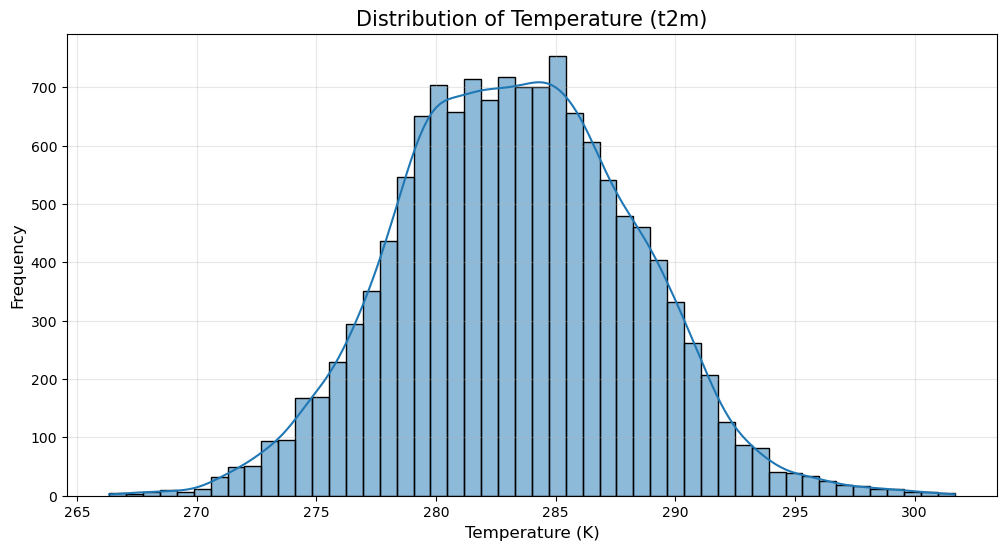

In [ ]:
# Distribution of target variable
plt.figure(figsize=(12, 6))
sns.histplot(dataTrain['t2m'].sample(N, random_state = randomState), kde=True, bins=50)
plt.title('Distribution of Temperature (t2m)', fontsize=15)
plt.xlabel('Temperature (K)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

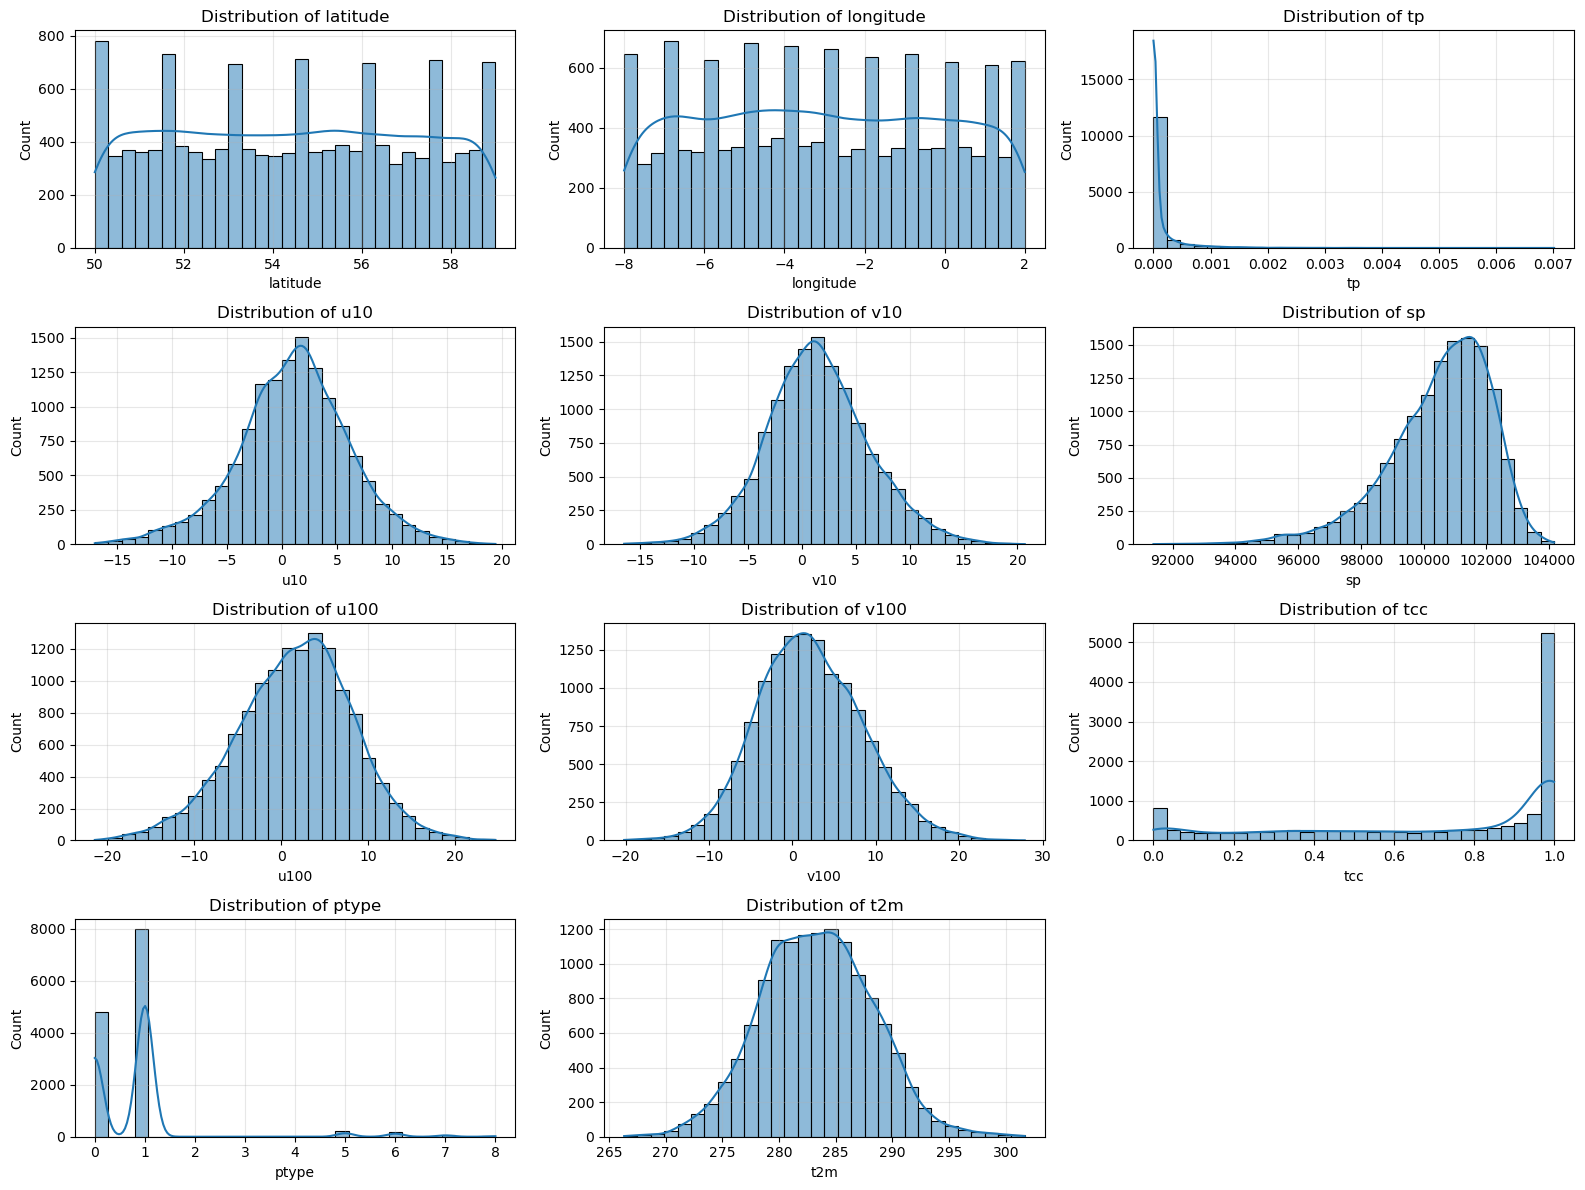

In [ ]:
# Plot distributions of all continuous features (excluding datetime and ID)
numeric_cols = dataTrain.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in ['id', 'year', 'month', 'day', 'hour', 'dayofweek', 'dayofyear']]
plot_feature_distributions(dataTrain.sample(N, random_state = randomState), columns=numeric_cols)

#### 1.6 Plot Distributions of Variables With Respect to Response

In [ ]:
# plotting distributions for each variable
# running with all entries in dataset takes ~10mins
# therefore run with random sample n from dataset
def plotResponseDistributions(data, x, y):
    plot = sns.PairGrid(data, x_vars = x, y_vars = y, height = 5, aspect = 1.5)
    plot.map(sns.scatterplot)

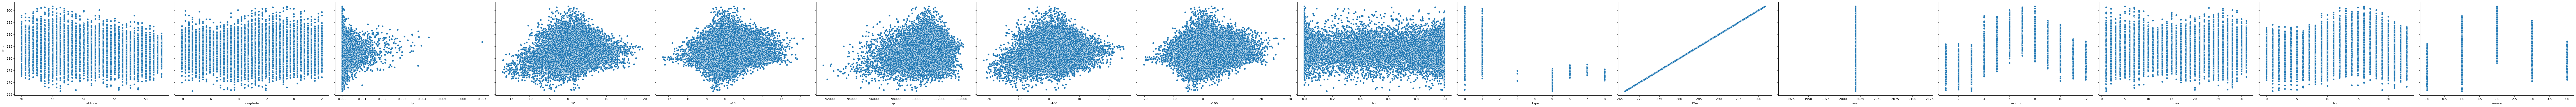

In [ ]:
plotResponseDistributions(dataTrain.sample(N, random_state = randomState), dataTrain.columns.tolist(), ["t2m"])

Below plots show temperature along the x-axis, and the variables along the y-axis. Initially wanted this the opposite way, but they displayed inline and too small to be properly legisble.

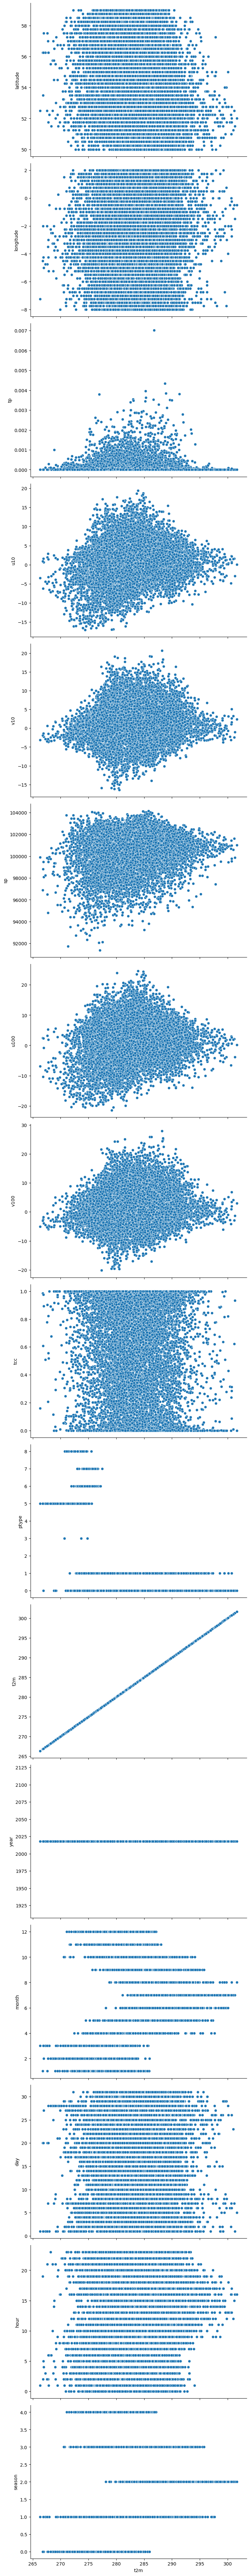

In [ ]:
plotResponseDistributions(dataTrain.sample(N, random_state = randomState), ["t2m"], dataTrain.columns.tolist())

The above plots show the distribution of the variables against the response (excluding valid_time, and ptype, for being datetime and categoric data respectively). We can see that "tcc" is uniformly disributed with the response i.e. it is appears completely uncorrelated/unrelated with the response. However, cloud cover prevents radiation in and out of Earth, preventing temperature changes -- therefore, having a high tcc may make increase time correlations with temperature.

The latitude, and longitude values have distributions which appear to vary with temperature, suggesting they are related. This matches our experience in the real world.

We see that the distributions for the windspeed variables: u10, v10, u100, and v100 have cross shapes. The 100 metre height winds have a wider, less tight, cross shape than the lower, 10 metre winds.

The total precipitation has a "bell"-ish shaped distribution with temperature. This makes sense, because for sufficiently high and low temperatures (near the UK) there is no rain, and there is no snow. Thus, rainy temperatures occur near the centre of the distribution.

The surface pressure distribution also shows a relation with the temperature, and should be analysed further.

#### 1.7 Geographic Distributions
Want to visualise the spatial compontent of temperature distributions.

#### 1.8 Cluster Locations
In order to take advantage of "nearby" features we shall cluster the locations.

First find the optimal number of clusters:

In [ ]:
# function prints the silhouette score for a given range of k clusters
def findOptimalClusters(data, range):
  print(f"k:\tSilhouetteScore:")
  silhouetteScores = []

  for k in range:
    kmeans = KMeans(n_clusters = k, random_state = randomState)
    labels = kmeans.fit_predict(data)
    score = silhouette_score(data, labels)
    silhouetteScores.append(score)
    print(f"{k},\t{score:.3f}")

  return np.argmax(silhouetteScores) + range[0]

In [ ]:
# turn latitude, longitude, and temperature into 3D coordinates
temperatureCoordinates = dataTrain[["latitude", "longitude", "t2m"]]

coordinateScaler = StandardScaler()
temperatureCoordinatesScaled = coordinateScaler.fit_transform(temperatureCoordinates) # <- need to normalise coordinates to run kmeans

In [ ]:
# use silhouette score score to find number of clusters
# takes a long time to run on whole data set hence sample coordinates
# use results from sampled data to infer the optimal result for whole dataset
temperatureCoordinatesSampled = temperatureCoordinates.sample(n = N, random_state = randomState)
temperatureCoordinatesSampledScaled = coordinateScaler.transform( temperatureCoordinatesSampled.values )

optimalK = findOptimalClusters(temperatureCoordinatesSampledScaled, range(2, 11))
print(f"\noptimal k = {optimalK}")

c:\Users\J\miniconda3\envs\ID5059\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\J\miniconda3\envs\ID5059\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


k:	SilhouetteScore:
2,	0.262


c:\Users\J\miniconda3\envs\ID5059\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


3,	0.263


c:\Users\J\miniconda3\envs\ID5059\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


4,	0.276


c:\Users\J\miniconda3\envs\ID5059\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


5,	0.284


c:\Users\J\miniconda3\envs\ID5059\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


6,	0.287


c:\Users\J\miniconda3\envs\ID5059\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


7,	0.276


c:\Users\J\miniconda3\envs\ID5059\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


8,	0.267


c:\Users\J\miniconda3\envs\ID5059\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


9,	0.262


c:\Users\J\miniconda3\envs\ID5059\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


10,	0.257

optimal k = 6


Optimal number of clusters is found to be k = 6. Use this to cluster data.

In [ ]:
# now clustering over whole dataset
kmeans = KMeans(n_clusters = optimalK, random_state = randomState)
coordinateData = kmeans.fit_predict(temperatureCoordinatesScaled)

c:\Users\J\miniconda3\envs\ID5059\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
dataTrain.head(2)

latitude  longitude        tp       u10       v10        sp      u100   
0      59.0      -8.00  0.000004  1.405868 -1.367767  98134.81  1.516388  \
1      59.0      -7.75  0.000017  2.151962 -1.555267  98086.81  2.239044   

       v100       tcc  ptype        t2m  year  month  day  hour  season  
0 -1.468002  0.968842    1.0  279.75903  2018      1    1     0       0  
1 -1.634994  0.978790    1.0  279.61255  2018      1    1     0       0

In [ ]:
pd.DataFrame(coordinateData).value_counts(normalize = True)

3    0.199847
2    0.188231
0    0.159828
1    0.156478
4    0.150223
5    0.145393
Name: proportion, dtype: float64

Clusters are not evenly weighted.

Plot Clusters:

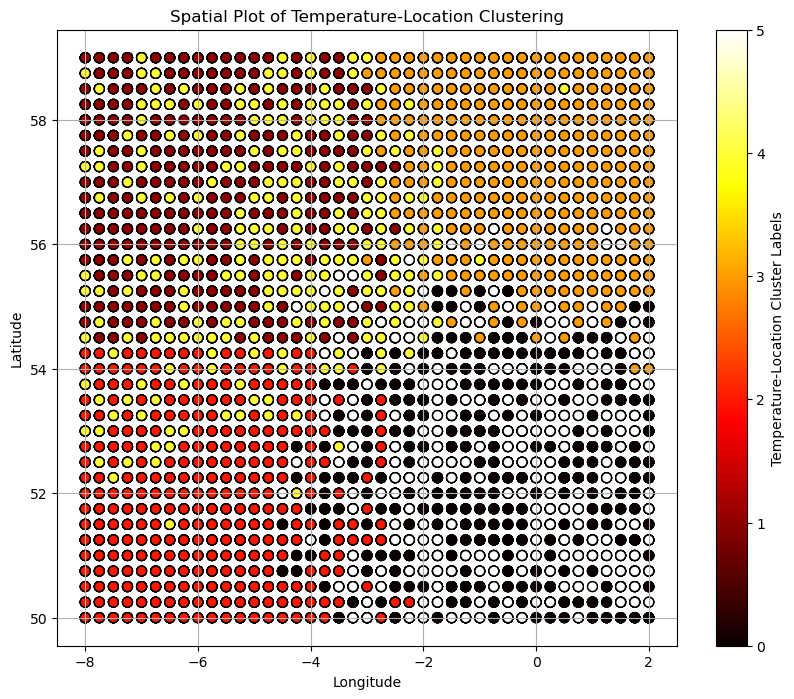

In [ ]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(dataTrain.sample(n = N, random_state = randomState)["longitude"],
                      dataTrain.sample(n = N, random_state = randomState)["latitude"],
                      c = pd.DataFrame(coordinateData).sample(n = N, random_state = randomState),
                      cmap = "hot", s = 50, edgecolor = "k")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Spatial Plot of Temperature-Location Clustering")
plt.colorbar(scatter, label= "Temperature-Location Cluster Labels")
plt.grid(True)
plt.show()

### 2. Model Development and Selection

#### 2.1 Pipeline Creation

In [ ]:
def encodeData(data, one_hot_attributes, numerical_attributes):
    y = data["t2m"].to_numpy("float32")

    onehot_pipeline = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy = "most_frequent")),
        ("onehot", OneHotEncoder(sparse_output = True, handle_unknown = "ignore"))
    ])

    # Defining pipeline for numerical scaling
    numerical_pipeline = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy = "median")),
        ("scaler", StandardScaler())
    ])

    full_pipeline = ColumnTransformer(
        transformers = [
            ("cat-onehot", onehot_pipeline, one_hot_attributes),
            ("numerical", numerical_pipeline, numerical_attributes)
        ],
        remainder = "drop",
        sparse_threshold = 1.0
    )
    
    x = full_pipeline.fit_transform( data )
    return x, y

In [ ]:
attributes = list(dataTrain.columns)
one_hot_attributes = ["year", "month", "day", "hour", "season", "ptype"]
numerical_attributes = list(filter(lambda item: item not in one_hot_attributes + ["t2m"], attributes))
print(one_hot_attributes)
print(numerical_attributes)

['year', 'month', 'day', 'hour', 'season', 'ptype']
['latitude', 'longitude', 'tp', 'u10', 'v10', 'sp', 'u100', 'v100', 'tcc']


In [ ]:
x_train, y_train = encodeData(dataTrain, one_hot_attributes, numerical_attributes)

#### 2.2 Implement Neural Network

In [ ]:
# Define the model
model = keras.models.Sequential([
    keras.layers.Input(( x_train.shape [1], )),
    keras.layers.Dense(16, activation = "relu"),
    keras.layers.Dense(16, activation = "relu"),
    keras.layers.Dense(1, activation = "linear")
])

# Make Predictions
#predictions = model.predict( x_test )
#predicted_classes = np.argmax(predictions, axis =1)

In [ ]:
# Compile the model
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate = 0.01),
    loss = "mse",
    #metrics = [
    #    keras.metrics.R2Score(class_aggregation="uniform_average", num_regressors=0, name="r2_score", dtype=None)
    #    ]
)

In [ ]:
# Train the model
model.fit( x_train, y_train, epochs = 2, batch_size = 8 )

Epoch 1/2


c:\Users\J\miniconda3\envs\ID5059\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 16), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
